In [1]:
from mbdvv import app

import numpy as np
from glob import glob
import pandas as pd
from math import ceil

from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
def savefig(fig, name, ext='pdf', **kwargs):
    fig.savefig(f'../media/{name}.{ext}', transparent=True, bbox_inches='tight', **kwargs)

In [3]:
def reduced_grad(x):
    return x.rho_grad_norm/(2*(3*np.pi**2)**(1/3)*x.rho*(4/3))

def alpha_kin(x):
    return (x.kin_dens-x.rho_grad_norm**2/(8*x.rho))/(3/10*(3*np.pi**2)**(2/3)*x.rho**(5/3))

In [4]:
with app.context():
    filename = app.get_route('s66')[0].loc(0)['Water ... Water', 1.0, 'fragment-1'].gridfile

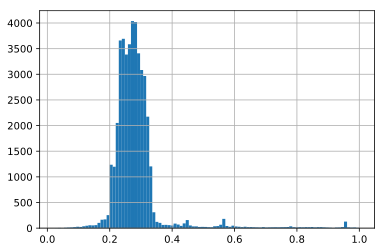

In [5]:
pd.read_hdf(filename).loc[lambda x: x.rho > 0].pipe(reduced_grad).loc[lambda x: x < 1].hist(bins=100);

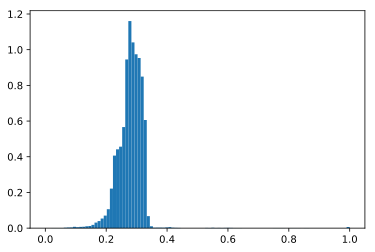

In [6]:
bins = np.linspace(0, 1, 100)
binmids = (bins[1:]+bins[:-1])/2 
subsums = (
    pd.read_hdf(filename)
    .assign(
        vv_pol_w=lambda x: x.vv_pol*x.part_weight,
        binidx=lambda x: np.digitize(reduced_grad(x).clip(bins[0]+1e-10, bins[-1]-1e-10), bins),
    ).groupby('binidx')
    .apply(lambda x: x.vv_pol_w.sum())
)
fig, ax = plt.subplots()
ax.bar(binmids[subsums.index-1], subsums, bins[1]-bins[0]);

In [7]:
with app.context():
    df = app.get_route('solids')[0]['solids']

In [8]:
all_points = pd.concat(
    dict(df.gridfile.loc[:, 1., 'crystal'].apply(lambda x: pd.read_hdf(x))),
    names=('level', 'i_point')
)

In [9]:
all_points.to_hdf('../data/grid-points.h5', 'grid_points')

In [10]:
bins = np.linspace(0, 1, 50)
binmids = (bins[1:]+bins[:-1])/2 
subsums = (
    all_points
    .assign(
        vv_pol_w=lambda x: x.vv_pol*x.part_weight,
        binidx=lambda x: np.digitize(reduced_grad(x).clip(bins[0]+1e-10, bins[-1]-1e-10), bins),
    ).groupby('level binidx'.split())
    .apply(lambda x: x.vv_pol_w.sum())
)

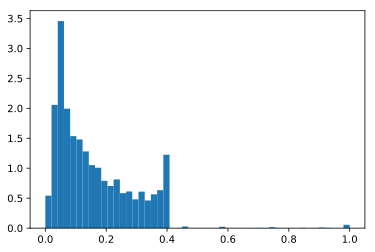

In [11]:
df =  list(subsums.groupby('level'))[0][1]
fig, ax = plt.subplots()
ax.bar(binmids[df.index.get_level_values('binidx')-1], df, bins[1]-bins[0]);

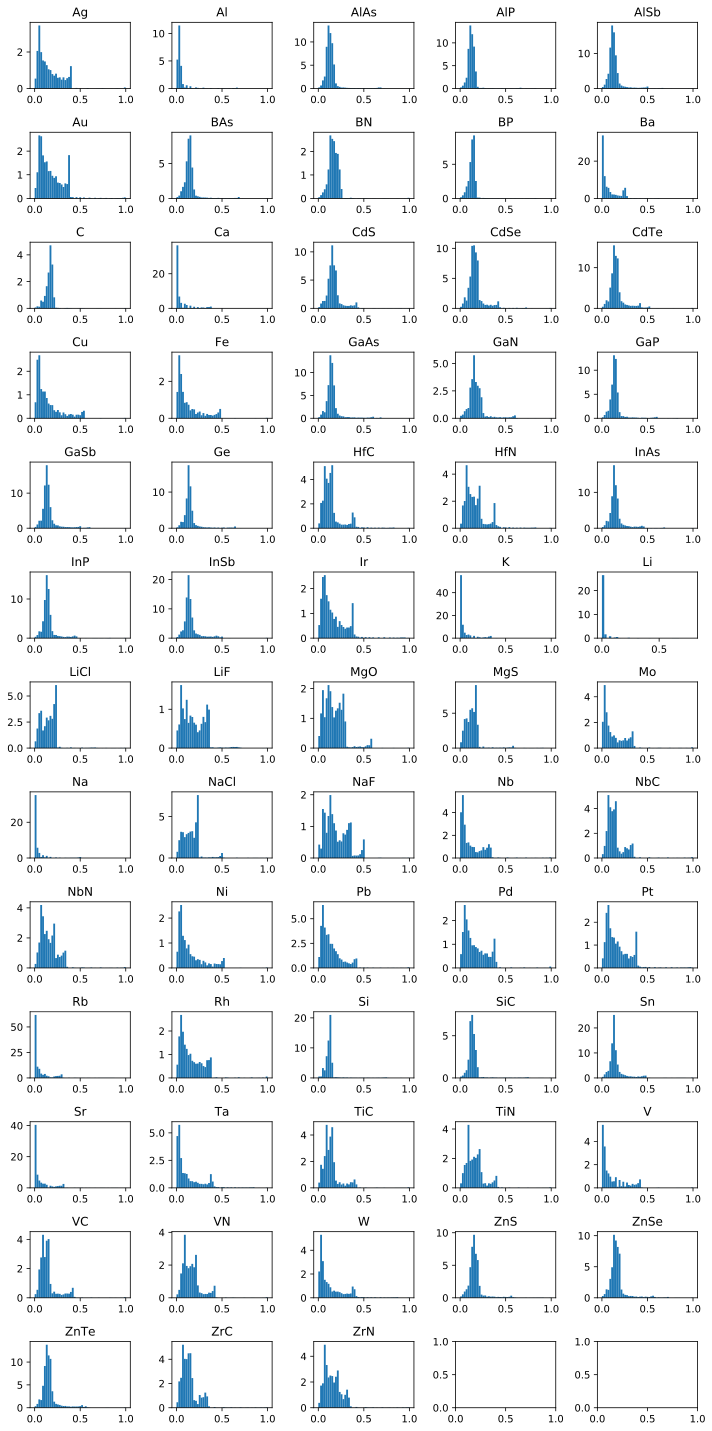

In [12]:
nrow = 5
fig, axes = plt.subplots(ceil(len(subsums.index.levels[0])/5), 5, figsize=(10, 20))
for ax, (label, df) in zip((ax for ax_row in axes for ax in ax_row), subsums.groupby('level')):
    ax.bar(binmids[df.index.get_level_values('binidx')-1], df, bins[1]-bins[0])
    ax.set_title(label)
fig.tight_layout()

In [13]:
savefig(fig, 'alpha-rgrad-hists')